In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

#from sklearn.metrics import accuracy_score, f1_score, recall_score

In [2]:
import os 
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

### set data file locations

In [7]:
IMG_PATH = r"/home/alex/data/wir/raffineurs"
IMG_INVENTORY_PATH = 'app/static/img_inventory.csv'
IMG_STATIC_LIST = ['1015-8599-large_default-votre-portrait-dans-un-studio-du-xixeme-siecle.jpg',
 '1033-8975-large_default-mug-egoist-feminisit-anarchist-pessimist-optimist.jpg',
 '1058-14147-large_default-t-shirt-smoking-pipe.jpg',
 '1087-9246-large_default-cube-en-bois-magnetique.jpg',
 '1128-13515-large_default-rendez-vous-pour-creer-votre-creme-sur-mesure.jpg',
 '1160-9831-large_default-un-terrarium-a-composer-soi-meme.jpg',
 '1191-10092-large_default-maillot-de-bain-iguazu.jpg',
 '1215-10321-large_default-affiche-50-choses-a-faire-dans-une-vie.jpg',
 '1244-10653-large_default-carnet-de-projets.jpg',
 '1261-10675-large_default-affiches-ville-mondrian.jpg']

In [20]:
with open("imagenet_classes_to_labels_map.txt") as f:
    labels = eval(f.read())

### set calc location

In [9]:
if torch.cuda.is_available():  
    dev = "cuda:1" 
else:  
    dev = "cpu"  
device = torch.device(dev)
device = torch.device('cpu')

### load model

In [10]:
import torchvision.models as models

net = models.resnet101(pretrained=True)
net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### load and transform data

In [13]:
from torchvision import transforms
from utils import ToRGB
transform = transforms.Compose([            #[1]
 ToRGB(),
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [135]:
imgs = os.listdir(IMG_PATH)

In [12]:
imgs[0]

'1191-10092-large_default-maillot-de-bain-iguazu.jpg'

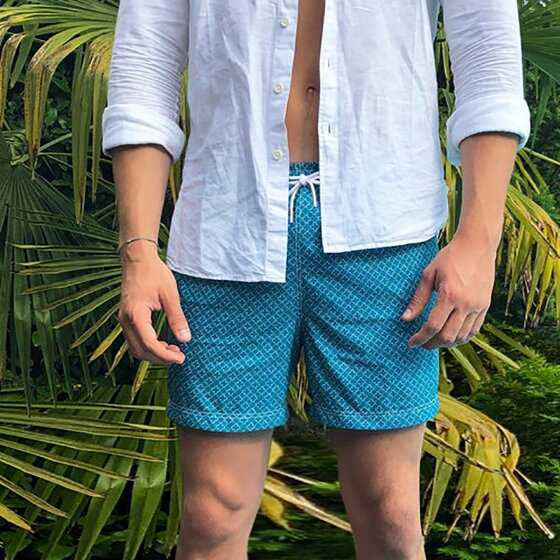

In [137]:
from PIL import Image               # to load images
from IPython.display import display # to display images
img_path = os.path.join(IMG_PATH, imgs[0])
img = Image.open(img_path)
display(img)

### test model inference

In [138]:
output = net(transform(img).unsqueeze(0))

In [139]:
_, indices = torch.sort(output[[0][:]], descending=True)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
[(labels[idx.item()], percentage[idx].item()) for idx in indices[0][:10]]

[('swimming trunks, bathing trunks', 33.866004943847656),
 ('sandal', 13.779561042785645),
 ('miniskirt, mini', 9.65006160736084),
 ('clog, geta, patten, sabot', 6.854707717895508),
 ('sunglasses, dark glasses, shades', 5.250972270965576),
 ('jean, blue jean, denim', 4.7496209144592285),
 ('sarong', 4.2452802658081055),
 ('cowboy boot', 3.644996166229248),
 ('apron', 2.5815606117248535),
 ('running shoe', 1.694585919380188)]

# run inference across full dataset

In [47]:
df = pd.DataFrame(columns=['prod_id','img_id','image_name']+list(labels.keys()))
df['prod_id'] = [img.split('-')[0] for img in IMG_STATIC_LIST]
df['img_id'] = [img.split('-')[1] for img in IMG_STATIC_LIST]
df['image_name'] = IMG_STATIC_LIST

In [92]:
for i, image_name in enumerate(df.image_name):
    print(i, image_name)
    
    # load image
    img_path = os.path.join(IMG_PATH, image_name)
    img = Image.open(img_path)
    
    # infer classes
    output = net(transform(img).unsqueeze(0))
    _, indices = torch.sort(output[[0][:]], descending=True)
    percentage = torch.nn.functional.softmax(output, dim=1)[0]
    
    # store in dataframe
    df.loc[i, df.columns[3:]] = percentage.detach().numpy()

0 1015-8599-large_default-votre-portrait-dans-un-studio-du-xixeme-siecle.jpg
1 1033-8975-large_default-mug-egoist-feminisit-anarchist-pessimist-optimist.jpg
2 1058-14147-large_default-t-shirt-smoking-pipe.jpg
3 1087-9246-large_default-cube-en-bois-magnetique.jpg
4 1128-13515-large_default-rendez-vous-pour-creer-votre-creme-sur-mesure.jpg
5 1160-9831-large_default-un-terrarium-a-composer-soi-meme.jpg
6 1191-10092-large_default-maillot-de-bain-iguazu.jpg
7 1215-10321-large_default-affiche-50-choses-a-faire-dans-une-vie.jpg
8 1244-10653-large_default-carnet-de-projets.jpg
9 1261-10675-large_default-affiches-ville-mondrian.jpg


In [132]:
def get_topn_labels(row, n=10):
    outdf = row.astype(float).nlargest(n).reset_index()
    outdf.columns = ['label_id','percentage']
    outdf['label_name'] = outdf.label_id.map(labels)
    return outdf

In [133]:
labelled_df = df.loc[:, df.columns[:3]].copy()
labelled_df['content'] = ''

for i, image_name in enumerate(df.image_name):
    topnlabels = get_topn_labels(df.loc[i, df.columns[3:]])
    labelled_df.loc[i, 'content'] = ' '.join(topnlabels.label_name.tolist())

In [134]:
labelled_df

,prod_id,img_id,image_name,content
0,1015,8599,1015-8599-large_default-votre-portrait-dans-un...,"wardrobe, closet, press perfume, essence bow t..."
1,1033,8975,1033-8975-large_default-mug-egoist-feminisit-a...,"coffee mug cup lotion pill bottle saltshaker, ..."
2,1058,14147,1058-14147-large_default-t-shirt-smoking-pipe.jpg,"mailbag, postbag wool, woolen, woollen purse b..."
3,1087,9246,1087-9246-large_default-cube-en-bois-magnetiqu...,"shower curtain washbasin, handbasin, washbowl,..."
4,1128,13515,1128-13515-large_default-rendez-vous-pour-cree...,"loupe, jeweler's loupe face powder stethoscope..."
5,1160,9831,1160-9831-large_default-un-terrarium-a-compose...,"beaker pot, flowerpot vase broccoli soap dispe..."
6,1191,10092,1191-10092-large_default-maillot-de-bain-iguaz...,"swimming trunks, bathing trunks sandal miniski..."
7,1215,10321,1215-10321-large_default-affiche-50-choses-a-f...,"wine bottle perfume, essence restaurant, eatin..."
8,1244,10653,1244-10653-large_default-carnet-de-projets.jpg,"envelope binder, ring-binder carton book jacke..."
9,1261,10675,1261-10675-large_default-affiches-ville-mondri...,"crib, cot wardrobe, closet, press bookcase des..."
